In [1]:
import keras
from keras import backend as K
from keras.preprocessing import image
from keras.applications.xception import preprocess_input, decode_predictions
from keras import regularizers

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

from IPython.display import display, HTML

from keras_tqdm import TQDMNotebookCallback

Using TensorFlow backend.


In [2]:
# Hack to fix TQDM extra lines issue...
# Reference: https://github.com/bstriner/keras-tqdm/issues/21
from keras_tqdm import TQDMNotebookCallback
display(HTML("""
    <style>
        .p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
              padding: 0;
              border: 0;
        }
    </style>
"""))

In [3]:
def grab_image(img_path, x, y):
    img = image.load_img(img_path, color_mode = "grayscale", target_size=(x,y))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [4]:
def get_csv(n, path) :
    data = pd.read_csv(path, header=None)
    output = data[0].values
    
    if n == 0 :
        return output
    else :
        return output[:n]

In [5]:

num_images = 900
human_scores = get_csv(num_images, '/home/djw4s/miscImgs/scores/humanScores.txt')
print(human_scores.shape)

(900,)


In [6]:
images = np.concatenate([grab_image('/home/djw4s/miscImgs/models/%d_model.png'%(i), 100, 100) for i in range(num_images)])

images /= 255
print(images.shape)

(900, 100, 100, 1)


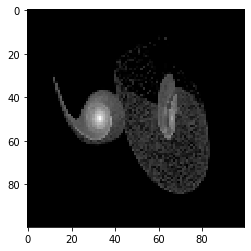

0.72973

In [7]:
plt.imshow(image.array_to_img(images[45,:,:,:]), cmap='Greys_r')
plt.show()
display(human_scores[45])

In [8]:
p = np.random.permutation(len(images))
Xshuffled = images[p]
Yshuffled = human_scores[p]

display(Xshuffled.shape)
display(Yshuffled.shape)

(900, 100, 100, 1)

(900,)

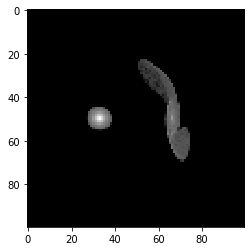

0.05714299999999999

In [9]:
plt.imshow(image.array_to_img(Xshuffled[0,:,:,:]), cmap='Greys_r')
plt.show()
display(Yshuffled[0])

In [10]:
x_train = Xshuffled[0:(round(num_images*.85)),:,:]
y_train = Yshuffled[0:(round(num_images*.85))]
x_test = Xshuffled[(round(num_images*.85)): , : , :]
y_test = Yshuffled[(round(num_images*.85)):]

display(x_train.shape)
display(y_train.shape)
display(x_test.shape)
display(y_test.shape)

(765, 100, 100, 1)

(765,)

(135, 100, 100, 1)

(135,)

# Model One
---

In [11]:
model = keras.Sequential()
# 1st block:
model.add(keras.layers.Conv2D(16,
                              kernel_size=(12,12),
                              padding='same', 
                              activation='relu',
                              input_shape=[x_train.shape[1],
                                           x_train.shape[2],
                                           x_train.shape[3]
                                          ]
                             )
         )
model.add(keras.layers.Conv2D(16,
                              (8, 8),
                              activation='relu',
                              strides=2
                             )
         )
model.add(keras.layers.MaxPooling2D(pool_size=(4, 4)))
model.add(keras.layers.Dropout(0.3))
# 2nd block:
model.add(keras.layers.Conv2D(8,
                              kernel_size=(4,4),
                              padding='same', 
                              activation='relu',
                              #input_shape=[x_train.shape[1],
                              #             x_train.shape[2],
                              #             x_train.shape[3]
                              #            ]
                             )
         )
#model.add(keras.layers.Conv2D(256,
 #                             (4, 4),
  #                            activation='relu',
   #                           strides=(2,2)
    #                         )
     #    )
#model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(keras.layers.Dropout(0.3))
# Dense Layers:
model.add(keras.layers.Flatten())
'''
model.add(keras.layers.Dense(16, 
                             activation='relu')
         )
model.add(keras.layers.Dense(32, 
                             activation='relu')
         )
model.add(keras.layers.Dropout(0.5))
'''
model.add(keras.layers.Dense(1, 
                             activation='sigmoid')
         )

model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adam(learning_rate=1E-3),
              metrics=['accuracy', 'mse']
             )
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 16)      2320      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 16)        16400     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 11, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 8)         2056      
_________________________________________________________________
flatten_1 (Flatten)          (None, 968)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [12]:
batch_size = 4
epochs = 60
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    callbacks=[TQDMNotebookCallback()],
                    validation_split=0.2
                   )
print('DONE')


DONE


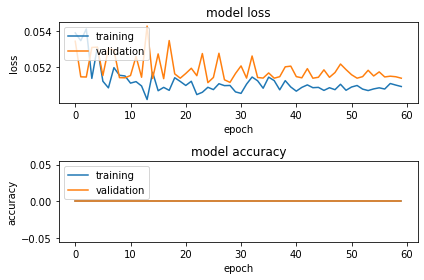

In [13]:
plt.figure(1)

plt.subplot(211)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'],loc='upper left')

plt.subplot(212)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'],loc='upper left')

plt.tight_layout()
plt.show()

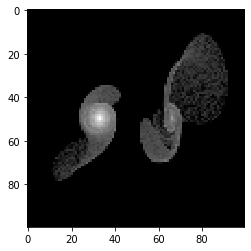

Human Score


0.676471

Prediction


0.29726392

In [14]:
preds = model.predict(x_test)
diff = preds.flatten() - (y_test)
absDiff = np.abs(diff)
top10 = np.argpartition(absDiff, -10)[-10:]

plt.imshow(image.array_to_img(x_test[top10[0],:,:,:]), cmap='Greys_r') 
plt.show()

print("Human Score")
display(y_test[top10[0]])
print("Prediction")
display(preds[top10[0]][0])

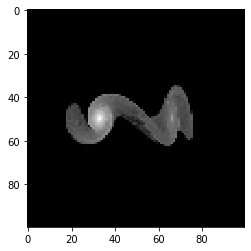

Human Score


0.864865

Prediction


0.29726392

In [15]:
plt.imshow(image.array_to_img(x_test[top10[1],:,:,:]), cmap='Greys_r') 
plt.show()

print("Human Score")
display(y_test[top10[1]])
print("Prediction")
display(preds[top10[1]][0])

# Test Two
***Match other network***

---

In [16]:
model = keras.Sequential()
# 1st block:
model.add(keras.layers.Conv2D(16,
                              kernel_size=(12,12),
                              activation='relu',
                              input_shape=[x_train.shape[1],
                                           x_train.shape[2],
                                           x_train.shape[3]
                                          ]
                             )
         )
model.add(keras.layers.Conv2D(16,
                              (8, 8),
                              activation='relu',
                             )
         )
model.add(keras.layers.MaxPooling2D(pool_size=(4, 4)))
model.add(keras.layers.Dropout(0.3))
# 2nd block:
model.add(keras.layers.Conv2D(8,
                              kernel_size=(4,4),
                              activation='relu',

                             )
         )
# Dense Layers:
model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(1, 
                             activation='sigmoid')
         )
# Compile
model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adam(learning_rate=1E-3),
              metrics=['mse']
             )
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 89, 89, 16)        2320      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 82, 82, 16)        16400     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 20, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 17, 17, 8)         2056      
_________________________________________________________________
flatten_2 (Flatten)          (None, 2312)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [17]:
batch_size = 4
epochs = 60
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    callbacks=[TQDMNotebookCallback()],
                    validation_split=0.3
                   )
print('DONE')


DONE


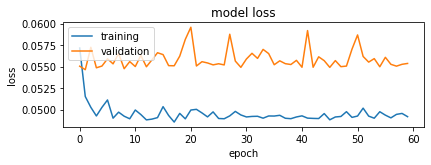

In [18]:
plt.figure(1)

plt.subplot(211)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'],loc='upper left')

plt.tight_layout()
plt.show()

In [19]:
preds = model.predict(x_test)
diff = preds.flatten() - (y_test)
print("Mean difference")
print("---------------")
display(np.mean(np.abs(diff)))

Mean difference
---------------


0.18618001278190613

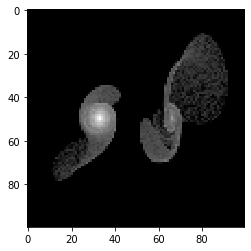

Human Score


0.676471

Prediction


0.29693362

In [20]:
preds = model.predict(x_test)
diff = preds.flatten() - (y_test)
absDiff = np.abs(diff)
top10 = np.argpartition(absDiff, -10)[-10:]

plt.imshow(image.array_to_img(x_test[top10[0],:,:,:]), cmap='Greys_r') 
plt.show()

print("Human Score")
display(y_test[top10[0]])
print("Prediction")
display(preds[top10[0]][0])

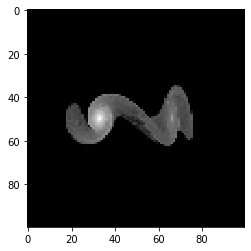

Human Score


0.864865

Prediction


0.29693362

In [21]:
plt.imshow(image.array_to_img(x_test[top10[1],:,:,:]), cmap='Greys_r') 
plt.show()

print("Human Score")
display(y_test[top10[1]])
print("Prediction")
display(preds[top10[1]][0])

# Test Three
---

In [22]:
model = keras.Sequential()
# 1st block:
model.add(keras.layers.Conv2D(32,
                              kernel_size=(12,12),
                              activation='relu',
                              input_shape=[x_train.shape[1],
                                           x_train.shape[2],
                                           x_train.shape[3]
                                          ],
                              kernel_regularizer=regularizers.l1(0.01),
                              activity_regularizer=regularizers.l1(0.01)
                             )
         )
model.add(keras.layers.Conv2D(16,
                              (10, 10),
                              activation='relu',
                              kernel_regularizer=regularizers.l1(0.01),
                              activity_regularizer=regularizers.l1(0.01)
                             )
         )
model.add(keras.layers.MaxPooling2D(pool_size=(4, 4)))
model.add(keras.layers.Dropout(0.5))

# Dense Layers:
model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(1, 
                             activation='sigmoid')
         )
# Compile
model.compile(loss=keras.losses.mean_squared_logarithmic_error,
              optimizer=keras.optimizers.Adam(learning_rate=1E-2),
              metrics=['mse']
             )
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 89, 89, 32)        4640      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 80, 80, 16)        51216     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 20, 16)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6401      
Total params: 62,257
Trainable params: 62,257
Non-trainable params: 0
__________________________________________________

In [23]:
batch_size = 24
epochs = 200
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    callbacks=[TQDMNotebookCallback()],
                    validation_split=0.3
                   )
print('DONE')

KeyboardInterrupt: 

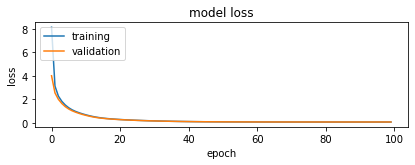

In [18]:
plt.figure(1)

plt.subplot(211)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'],loc='upper left')

plt.tight_layout()
plt.show()

In [19]:
preds = model.predict(x_test)
diff = preds.flatten() - (y_test)
print("Mean difference")
print("---------------")
display(np.mean(np.abs(diff)))

Mean difference
---------------


0.16866677269237662

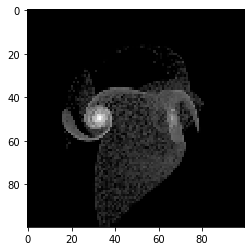

Human Score


0.694444

Prediction


0.21757844

In [20]:
preds = model.predict(x_test)
diff = preds.flatten() - (y_test)
absDiff = np.abs(diff)
top10 = np.argpartition(absDiff, -10)[-10:]

plt.imshow(image.array_to_img(x_test[top10[0],:,:,:]), cmap='Greys_r') 
plt.show()

print("Human Score")
display(y_test[top10[0]])
print("Prediction")
display(preds[top10[0]][0])

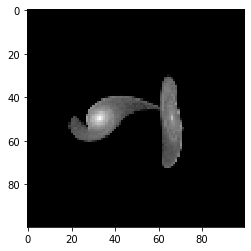

Human Score


0.714286

Prediction


0.21757844

In [21]:
plt.imshow(image.array_to_img(x_test[top10[1],:,:,:]), cmap='Greys_r') 
plt.show()

print("Human Score")
display(y_test[top10[1]])
print("Prediction")
display(preds[top10[1]][0])